In [ ]:
!pip install gymnasium[box2d]
!pip install stable-baselines3 matplotlib numpy


  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached swig-4.3.1-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (3.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (box2d-py)
  Using cached stable_baselines3-2.6.0-py3-none-any.whl.metadata (4.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.

In [ ]:
!apt-get install -y ffmpeg


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO
import matplotlib.pyplot as plt

# Create CartPole environment (simulates 2-wheel robot)
env = gym.make("CartPole-v1", render_mode="rgb_array")

# Train PPO model
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100_000)

# Save the model
model.save("ppo_self_balancing_robot")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 24.7     |
|    ep_rew_mean     | 24.7     |
| time/              |          |
|    fps             | 1079     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 28.7        |
|    ep_rew_mean          | 28.7        |
| time/                   |             |
|    fps                  | 798         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008218817 |
|    clip_fraction        | 0.0981      |
|    clip_range           | 0.2         |
|    entropy_loss   

In [ ]:
model = PPO.load("ppo_self_balancing_robot")

obs, _ = env.reset()
episode_rewards = []
total_reward = 0

for _ in range(500):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    if terminated or truncated:
        break

env.close()

# Show total reward
print(f"Total Reward: {total_reward}")


Total Reward: 500.0


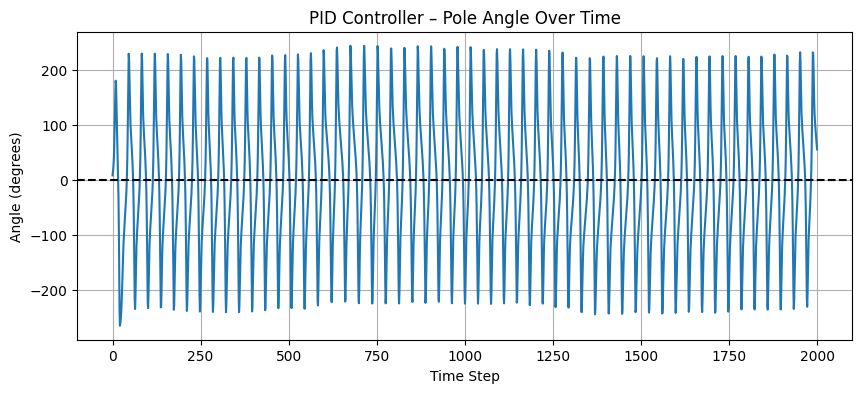

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === System Parameters ===
g = 9.8       # gravity (m/s²)
m_c = 1.0     # cart mass (kg)
m_p = 0.1     # pole mass (kg)
l = 0.5       # half-length of pole (m)
dt = 0.02     # time step (s)

# === PID Gains (tune these) ===
Kp = -100
Kd = -20
Ki = -10

# === Simulation Time ===
T = 10
N = int(T / dt)

# === Initial State === [x, x_dot, theta (rad), theta_dot]
state = np.array([0.0, 0.0, np.radians(8), 0.0])  # Start with slight tilt
integral_error = 0
prev_error = 0

# === Data Storage ===
angles = []
forces = []

for _ in range(N):
    x, x_dot, theta, theta_dot = state
    error = theta
    integral_error += error * dt
    derivative = (error - prev_error) / dt

    # === PID Control Force ===
    force = Kp * error + Ki * integral_error + Kd * derivative
    prev_error = error

    # === System Dynamics ===
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    total_mass = m_c + m_p
    temp = (force + m_p * l * theta_dot**2 * sin_theta) / total_mass
    theta_acc = (g * sin_theta - cos_theta * temp) / (l * (4.0/3 - m_p * cos_theta**2 / total_mass))
    x_acc = temp - m_p * l * theta_acc * cos_theta / total_mass

    # === Euler Integration ===
    x += x_dot * dt
    x_dot += x_acc * dt
    theta += theta_dot * dt
    theta_dot += theta_acc * dt

    state = np.array([x, x_dot, theta, theta_dot])

    # Store results
    angles.append(np.degrees(theta))
    forces.append(force)

# === Plot the Pole Angle ===
plt.figure(figsize=(10, 4))
plt.plot(angles)
plt.title("PID Controller – Pole Angle Over Time")
plt.xlabel("Time Step")
plt.ylabel("Angle (degrees)")
plt.grid(True)
plt.axhline(0, linestyle='--', color='black')
plt.show()


In [ ]:
# Convert angle list to numpy array
angles = np.array(angles)

# === Mean Squared Error (MSE) ===
mse = np.mean((angles - 0)**2)

# === Overshoot ===
overshoot = np.max(np.abs(angles))

# === Settling Time (within ±5 degrees) ===
tolerance = 5  # degrees
settling_time = None
for i in range(len(angles)):
    if np.all(np.abs(angles[i:]) < tolerance):
        settling_time = i * dt
        break

# === Show results ===
print(f"PID Performance:")
print(f"  MSE: {mse:.2f}")
print(f"  Overshoot: {overshoot:.2f}°")
if settling_time is not None:
    print(f"  Settling Time: {settling_time:.2f} s")
else:
    print("  Settling Time: Not settled within simulation duration")

PID Performance:
  MSE: 15773.93
  Overshoot: 264.80°
  Settling Time: Not settled within simulation duration


NameError: name 'cart_positions' is not defined

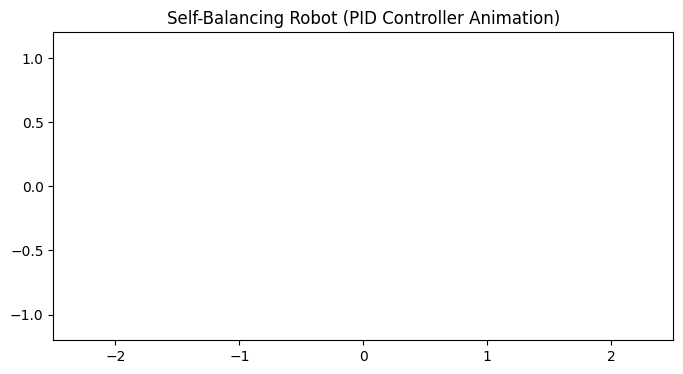

In [ ]:
from matplotlib.animation import FuncAnimation

# === Setup Figure ===
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-1.2, 1.2)
ax.set_title("Self-Balancing Robot (PID Controller Animation)")

# Robot elements
cart, = ax.plot([], [], 'k-', lw=6)     # wheels/cart base
pole, = ax.plot([], [], 'r-', lw=3)     # body/pole
trail, = ax.plot([], [], 'b:', lw=1)    # trail of cart movement

# Store trail
x_trail = []

def animate(i):
    x = cart_positions[i]
    theta = np.radians(angles[i])  # convert back to radians
    cart_width = 0.4
    pole_len = l * 2

    # Update cart line
    cart.set_data([x - cart_width/2, x + cart_width/2], [0, 0])

    # Update pole (robot body)
    pole_x = [x, x + pole_len * np.sin(theta)]
    pole_y = [0, pole_len * np.cos(theta)]
    pole.set_data(pole_x, pole_y)

    # Add to trail
    x_trail.append(x)
    trail.set_data(x_trail, [0]*len(x_trail))

    return cart, pole, trail

# Create the animation
ani = FuncAnimation(fig, animate, frames=len(cart_positions), interval=20)
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

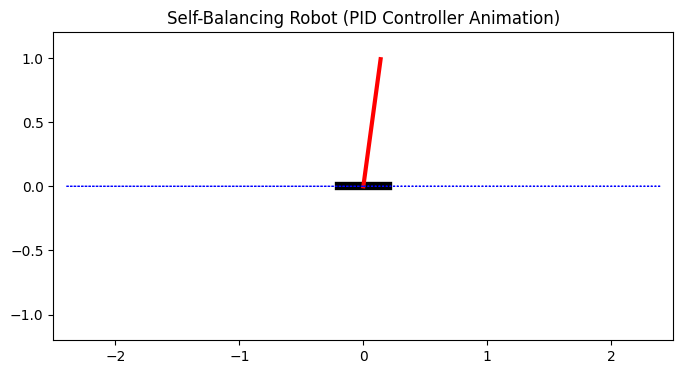

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# === System Parameters ===
g = 9.8
m_c = 1.0
m_p = 0.1
l = 0.5
dt = 0.02

# === PID Gains ===
Kp = -100
Kd = -20
Ki = -10

# === Simulation Settings ===
T = 40
dt = 0.02
N = int(T / dt)

# === Initial State === [x, x_dot, theta, theta_dot]
state = np.array([0.0, 0.0, np.radians(8), 0.0])
integral_error = 0
prev_error = 0

# === Data Storage ===
angles = []
cart_positions = []

# === Simulation Loop ===
for _ in range(N):
    x, x_dot, theta, theta_dot = state
    error = theta
    integral_error += error * dt
    derivative = (error - prev_error) / dt

    # PID Control Force
    force = Kp * error + Ki * integral_error + Kd * derivative
    prev_error = error

    # Add random disturbance
    force += np.random.normal(0, 5)

    # Dynamics
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    total_mass = m_c + m_p
    temp = (force + m_p * l * theta_dot**2 * sin_theta) / total_mass
    theta_acc = (g * sin_theta - cos_theta * temp) / (l * (4.0/3 - m_p * cos_theta**2 / total_mass))
    x_acc = temp - m_p * l * theta_acc * cos_theta / total_mass

    # Euler Integration
    x += x_dot * dt
    x_dot += x_acc * dt
    theta += theta_dot * dt
    theta_dot += theta_acc * dt

    state = np.array([x, x_dot, theta, theta_dot])

    # === Save for Plotting and Animation ===
    angles.append(np.degrees(theta))
    cart_positions.append(x)
    pid_angles = angles.copy()

# === Animation ===
from matplotlib.animation import FuncAnimation

# === Set up the figure ===
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-1.2, 1.2)
ax.set_title("Self-Balancing Robot (PID Controller Animation)")

# Plot elements
cart, = ax.plot([], [], 'k-', lw=6)     # cart
pole, = ax.plot([], [], 'r-', lw=3)     # pole
trail, = ax.plot([], [], 'b:', lw=1)    # cart trail

# Store trail data
x_trail = []

def animate(i):
    # Safely clip the cart's position to keep it inside plot bounds
    x = np.clip(cart_positions[i], -2.4, 2.4)
    theta = np.radians(angles[i])  # back to radians

    cart_width = 0.4
    pole_len = l * 2

    # Update cart line
    cart.set_data([x - cart_width/2, x + cart_width/2], [0, 0])

    # Update pole (robot body)
    pole_x = [x, x + pole_len * np.sin(theta)]
    pole_y = [0, pole_len * np.cos(theta)]
    pole.set_data(pole_x, pole_y)

    # Update trail
    x_trail.append(x)
    trail.set_data(x_trail, [0]*len(x_trail))

    return cart, pole, trail

# === Create animation ===
ani = FuncAnimation(fig, animate, frames=len(cart_positions), interval=1000 * dt)

# === Save the animation as MP4 ===
ani.save("self_balancing_robot_pid.mp4", writer="ffmpeg", fps=30, dpi=200)

# === Download the video in Colab ===
from google.colab import files
files.download("self_balancing_robot_pid.mp4")




In [ ]:
import numpy as np

obs, _ = env.reset()
cart_positions = []
angles = []

for _ in range(500):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    # Get x and theta
    x = np.clip(obs[0], -2.4, 2.4)         # clip to screen bounds
    theta = np.clip(obs[2], -np.pi/2, np.pi/2)  # keep pole upright (±90°)

    cart_positions.append(x)
    angles.append(np.degrees(theta))  # degrees for animation
    ppo_angles = angles.copy()
    if terminated or truncated:
        break


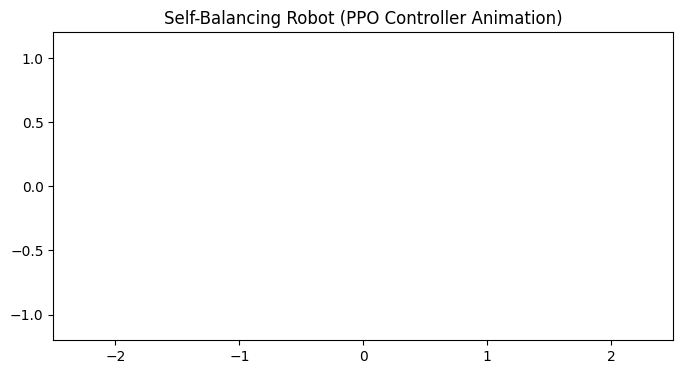

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-1.2, 1.2)
ax.set_title("Self-Balancing Robot (PPO Controller Animation)")

# Drawing elements
cart, = ax.plot([], [], 'k-', lw=6)     # cart base
pole, = ax.plot([], [], 'g-', lw=3)     # green pole = PPO
trail, = ax.plot([], [], 'b:', lw=1)    # trail

x_trail = []

def animate(i):
    x = cart_positions[i]
    theta = np.radians(angles[i])

    cart_width = 0.4
    pole_len = 1.0

    # Cart line
    cart.set_data([x - cart_width/2, x + cart_width/2], [0, 0])

    # Pole line
    pole_x = [x, x + pole_len * np.sin(theta)]
    pole_y = [0, pole_len * np.cos(theta)]
    pole.set_data(pole_x, pole_y)

    # Motion trail
    x_trail.append(x)
    trail.set_data(x_trail, [0]*len(x_trail))

    return cart, pole, trail

ani = FuncAnimation(fig, animate, frames=len(cart_positions), interval=20)
plt.show()

ani.save("ppo_self_balancing_robot.mp4", writer="ffmpeg", fps=30, dpi=200)

from google.colab import files
files.download("ppo_self_balancing_robot.mp4")

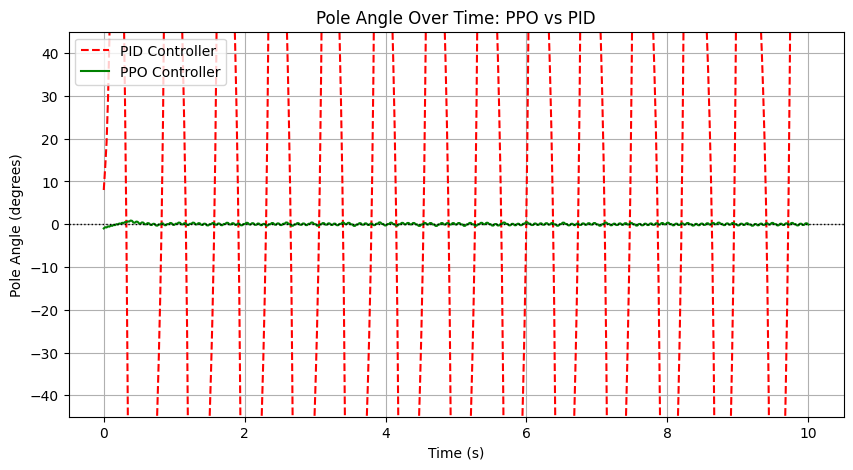

In [ ]:
# Plot PPO vs PID comparison
import matplotlib.pyplot as plt
import numpy as np

pid_angles = np.array(pid_angles)
ppo_angles = np.array(ppo_angles)

min_len = min(len(pid_angles), len(ppo_angles))
pid_angles = pid_angles[:min_len]
ppo_angles = ppo_angles[:min_len]
time = np.linspace(0, min_len * 0.02, min_len)

plt.figure(figsize=(10, 5))
plt.plot(time, pid_angles, label="PID Controller", color='red', linestyle='--')
plt.plot(time, ppo_angles, label="PPO Controller", color='green')
plt.axhline(0, color='black', linestyle=':', linewidth=1)

plt.title("Pole Angle Over Time: PPO vs PID")
plt.xlabel("Time (s)")
plt.ylabel("Pole Angle (degrees)")
plt.legend()
plt.grid(True)
plt.ylim(-45, 45)
plt.show()
